### Importing Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD


In [221]:
train = pd.read_csv('train_E6oV3lV.csv')
#train = train[0:1000]

In [222]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [223]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


<AxesSubplot:xlabel='label', ylabel='count'>

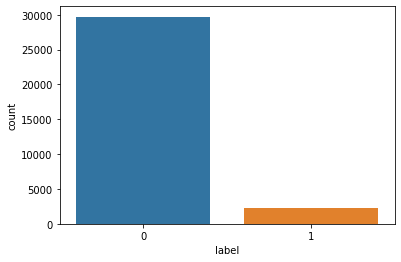

In [224]:
import seaborn as sns
sns.countplot(x="label", data = train)

In [7]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


## BERT

In [9]:
import os
os.environ['CURL_CA_BUNDLE'] = ''

In [10]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True,model_max_length=128)

### Encoding

In [11]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.tweet)):
        encoded = tokenizer.encode_plus(
        
        data.tweet[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [12]:
train_input_ids,train_attention_masks = bert_encode(train[:20000],60)
test_input_ids,test_attention_masks = bert_encode(train[:11962],60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Creating Model

In [14]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

In [15]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [16]:
model = create_model(bert_model)
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer 

In [17]:
dummy = train[:20000]
targets = dummy['label'].values

dummy2 = train[:11962]
targets_y = dummy2['label'].values

In [18]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []


#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d,3))

In [19]:
history_bert = model.fit([train_input_ids,train_attention_masks],targets,validation_data=([test_input_ids,test_attention_masks],targets_y), epochs=5,batch_size=4, steps_per_epoch=30, validation_steps= 30)

Epoch 1/5
30/30 [==============================] - 11s 169ms/step - loss: 0.4497 - accuracy: 0.8417 - f1_m: 0.0222 - precision_m: 0.0333 - recall_m: 0.0167 - val_loss: 0.3153 - val_accuracy: 0.9083 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
30/30 [==============================] - 3s 113ms/step - loss: 0.1942 - accuracy: 0.9667 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3171 - val_accuracy: 0.9083 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
30/30 [==============================] - 3s 113ms/step - loss: 0.2187 - accuracy: 0.9417 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3338 - val_accuracy: 0.9083 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/5
30/30 [==============================] - 3s 113ms/step - loss: 0.3254 - accuracy: 0.9167 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 

In [20]:
bert_acc = history_bert.history['val_accuracy'][4]
bert_prec = history_bert.history['val_precision_m'][4]
bert_rec = history_bert.history['val_recall_m'][4]
bert_f1 = history_bert.history['val_f1_m'][4]

storeResults('BERT',bert_acc,bert_prec,bert_rec,bert_f1)

### Visualizing BERT Performance

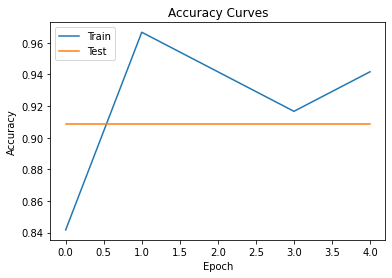

In [21]:
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

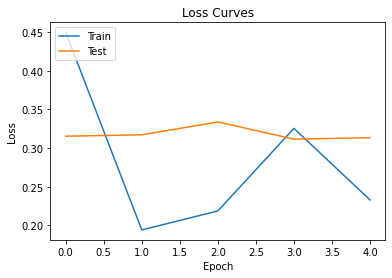

In [22]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Deep LEarning

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
import string

In [24]:
df = train
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [25]:
num_classes = df['label'].nunique()
print(num_classes)

2


In [26]:
def cleaning_text(text):
    stop_words = stopwords.words("english")

    text = re.sub(r'http\S+', " ", text)    # remove urls
    text = re.sub(r'@\w+',' ',text)         # remove mentions
    text = re.sub(r'#\w+', ' ', text)       # remove hastags
    text = re.sub('r<.*?>',' ', text)       # remove html tags
    
    # remove stopwords 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    
    return text

In [27]:
df['tweet'] = df['tweet'].apply(lambda x: cleaning_text(x))

In [28]:
# Maximum sentence length
max_len_words = max(list(df['tweet'].apply(len)))
print(max_len_words)

246


In [29]:
def tokenizer(x_train, y_train, max_len_word):
    # because the data distribution is imbalanced, "stratify" is used
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=.2, shuffle=True, 
                                                      stratify=y_train, random_state=0)

    # Tokenizer
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    sequence_dict = tokenizer.word_index
    word_dict = dict((num, val) for (val, num) in sequence_dict.items())

    # Sequence data
    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_word,
                                 truncating='post',
                                 padding='post')
    
    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                                maxlen=max_len_word,
                                truncating='post',
                                padding='post', )
    
    print(train_padded.shape)
    print(val_padded.shape)
    print('Total words: {}'.format(len(word_dict)))
    return train_padded, val_padded, y_train, y_val, word_dict

X_train, X_val, y_train, y_val, word_dict = tokenizer(df.tweet, df['label'], 100)

(25569, 100)
(6393, 100)
Total words: 25629


# Bi-LSTM

In [30]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32

model = Sequential([
    layers.Embedding(5000, 100, input_length=100),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4)),
    #layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4),
    #layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),    # or layers.Flatten()
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          84480     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 592,866
Trainable params: 592,866
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy',f1_m,precision_m, recall_m])  

In [37]:
trained = model.fit(X_train, y_train,
                    epochs=5, 
                    steps_per_epoch = 50,
                    validation_steps = 50,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/5
50/50 [==============================] - 59s 1s/step - loss: 0.2633 - accuracy: 0.9298 - f1_m: 0.1309 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2521 - val_accuracy: 0.9299 - val_f1_m: 0.1299 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 2/5
50/50 [==============================] - 59s 1s/step - loss: 0.2602 - accuracy: 0.9298 - f1_m: 0.1309 - precision_m: 0.0701 - recall_m: 1.0000 - val_loss: 0.2504 - val_accuracy: 0.9299 - val_f1_m: 0.1299 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 3/5
50/50 [==============================] - 59s 1s/step - loss: 0.2569 - accuracy: 0.9298 - f1_m: 0.1310 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2446 - val_accuracy: 0.9299 - val_f1_m: 0.1299 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 4/5
50/50 [==============================] - 59s 1s/step - loss: 0.2123 - accuracy: 0.9303 - f1_m: 0.1310 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.1783 - val_accuracy: 0.9406 - val_f1_m: 0.12

In [38]:
bilstm_acc = trained.history['val_accuracy'][4]
bilstm_prec = trained.history['val_precision_m'][4]
bilstm_rec = trained.history['val_recall_m'][4]
bilstm_f1 = trained.history['val_f1_m'][4]

storeResults('BiLSTM',bilstm_acc,bilstm_prec,bilstm_rec,bilstm_f1)

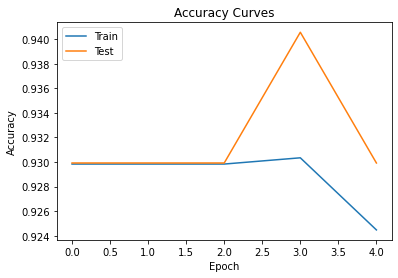

In [39]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

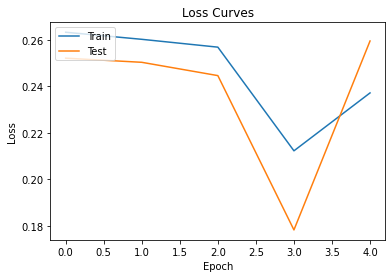

In [40]:
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# GRU

In [41]:
model = Sequential([
    layers.Embedding(5000, 100, input_length=100),
    layers.GRU(64, return_sequences=True, recurrent_dropout=0.4),
    layers.GlobalAveragePooling1D(),    # or layers.Flatten()
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [42]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [43]:
trained1 = model.fit(X_train, y_train,
                    epochs=5,
                     steps_per_epoch = 20,
                     validation_steps = 20,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/5
20/20 [==============================] - 13s 585ms/step - loss: 0.4753 - accuracy: 0.9086 - f1_m: 0.1310 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2562 - val_accuracy: 0.9299 - val_f1_m: 0.1304 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 2/5
20/20 [==============================] - 11s 570ms/step - loss: 0.2734 - accuracy: 0.9298 - f1_m: 0.1310 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2547 - val_accuracy: 0.9299 - val_f1_m: 0.1304 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 3/5
20/20 [==============================] - 11s 569ms/step - loss: 0.2616 - accuracy: 0.9298 - f1_m: 0.1311 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2510 - val_accuracy: 0.9299 - val_f1_m: 0.1304 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 4/5
20/20 [==============================] - 11s 570ms/step - loss: 0.2597 - accuracy: 0.9298 - f1_m: 0.1311 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2489 - val_accuracy: 0.9299 - va

In [44]:
gru_acc = trained.history['val_accuracy'][4]
gru_prec = trained.history['val_precision_m'][4]
gru_rec = trained.history['val_recall_m'][4]
gru_f1 = trained.history['val_f1_m'][4]

storeResults('GRU',gru_acc,gru_prec,gru_rec,gru_f1)

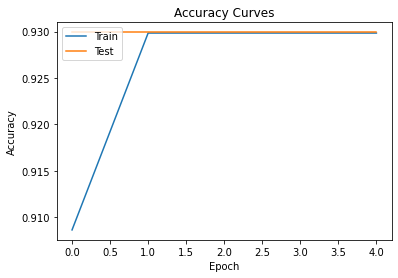

In [45]:
plt.plot(trained1.history['accuracy'])
plt.plot(trained1.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

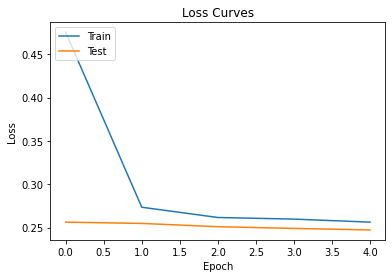

In [46]:
plt.plot(trained1.history['loss'])
plt.plot(trained1.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CNN

In [47]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten
def build_cnn_model():
    model = Sequential()
    
    model.add(Embedding(5000, 100, input_length=100))


    model.add(Conv1D(64, 2, padding='same', activation='relu'))
    model.add(MaxPooling1D(2))
    #model.add(MaxPooling1D(2))
    
    model.add(Flatten())
    
    model.add(Dense(units=1024,activation="relu"))
    model.add(Dense(units=512,activation="relu"))
    
    model.add(Dense(units=num_classes,activation="softmax"))
    
    optimizer = Adam(lr=0.000055,beta_1=0.9,beta_2=0.999)
    
    model.compile(optimizer=optimizer,metrics=["accuracy",f1_m,precision_m, recall_m],loss=tf.keras.losses.SparseCategoricalCrossentropy())
    return model

In [48]:
cnn_model = build_cnn_model()

In [49]:
cnn_history = cnn_model.fit(X_train, y_train,
                    epochs=5,
                    steps_per_epoch = 20,
                    validation_steps = 20,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/5
20/20 [==============================] - 3s 43ms/step - loss: 0.4728 - accuracy: 0.8879 - f1_m: 0.1311 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2885 - val_accuracy: 0.9299 - val_f1_m: 0.1304 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 2/5
20/20 [==============================] - 0s 25ms/step - loss: 0.2622 - accuracy: 0.9298 - f1_m: 0.1310 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2610 - val_accuracy: 0.9299 - val_f1_m: 0.1304 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 3/5
20/20 [==============================] - 0s 25ms/step - loss: 0.2557 - accuracy: 0.9298 - f1_m: 0.1311 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2538 - val_accuracy: 0.9299 - val_f1_m: 0.1304 - val_precision_m: 0.0701 - val_recall_m: 1.0000
Epoch 4/5
20/20 [==============================] - 0s 25ms/step - loss: 0.2537 - accuracy: 0.9298 - f1_m: 0.1311 - precision_m: 0.0702 - recall_m: 1.0000 - val_loss: 0.2532 - val_accuracy: 0.9299 - val_f1_m: 

In [50]:
cnn_acc = cnn_history.history['val_accuracy'][4]
cnn_prec = cnn_history.history['val_precision_m'][4]
cnn_rec = cnn_history.history['val_recall_m'][4]
cnn_f1 = cnn_history.history['val_f1_m'][4]

storeResults('CNN',cnn_acc,cnn_prec,cnn_rec,cnn_f1)

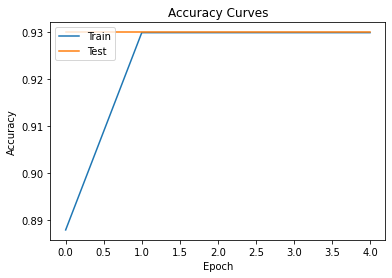

In [51]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

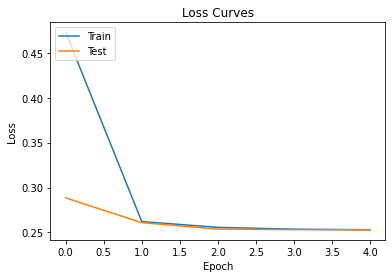

In [52]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CNN + LSTM

In [59]:
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras.layers import LSTM,Dropout,GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint

In [60]:
model = Sequential()
model.add(Embedding(5000, 100, input_length=100))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(units=num_classes, activation='sigmoid'))
model.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())
filepath="weights_best_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 563,034
Trainable params: 563,034
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
history = model.fit(X_train, y_train,
                    epochs=5, 
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/5
800/800 [==============================] - 12s 13ms/step - loss: 1.0729 - accuracy: 0.9101 - f1_m: 0.0011 - precision_m: 5.6677e-04 - recall_m: 0.0091 - val_loss: 1.0000 - val_accuracy: 0.9299 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
800/800 [==============================] - 10s 12ms/step - loss: 1.0000 - accuracy: 0.9307 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.9299 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
800/800 [==============================] - 10s 12ms/step - loss: 1.0000 - accuracy: 0.9299 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.9299 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/5
800/800 [==============================] - 10s 12ms/step - loss: 1.0000 - accuracy: 0.9295 - f1_m: 0.0000e+00 - precision_m: 

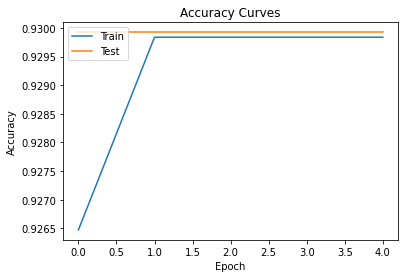

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

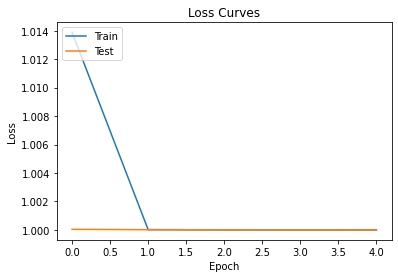

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [64]:
cnnlstm_acc = history.history['val_accuracy'][4]
cnnlstm_prec = history.history['val_precision_m'][4]
cnnlstm_rec = history.history['val_recall_m'][4]
cnnlstm_f1 = history.history['val_f1_m'][4]

storeResults('CNN+LSTM',cnnlstm_acc,cnnlstm_prec,cnnlstm_rec,cnnlstm_f1)

# CNN + BiLSTM

In [65]:
model = Sequential()
model.add(Embedding(5000, 100, input_length=100))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(units=num_classes, activation='sigmoid'))
model.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())
filepath="weights_best_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               106400    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 616,434
Trainable params: 616,434
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
history1 = model.fit(X_train, y_train,
                    epochs=5, 
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/5
800/800 [==============================] - 17s 17ms/step - loss: 1.0546 - accuracy: 0.9269 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.9299 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
800/800 [==============================] - 13s 16ms/step - loss: 1.0000 - accuracy: 0.9330 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.9299 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
800/800 [==============================] - 13s 16ms/step - loss: 1.0000 - accuracy: 0.9281 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.9299 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/5
800/800 [==============================] - 13s 16ms/step - loss: 1.0000 - accuracy: 0.9307 - f1_m: 0.0000e+00 - preci

In [68]:
cnnbilstm_acc = trained.history['val_accuracy'][4]
cnnbilstm_prec = trained.history['val_precision_m'][4]
cnnbilstm_rec = trained.history['val_recall_m'][4]
cnnbilstm_f1 = trained.history['val_f1_m'][4]

storeResults('CNN+BiLSTM',cnnbilstm_acc,cnnbilstm_prec,cnnbilstm_rec,cnnbilstm_f1)

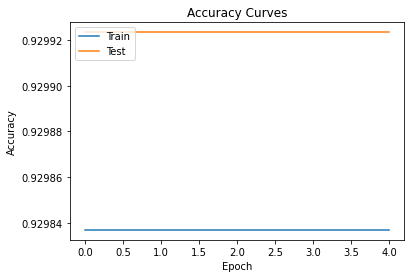

In [69]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

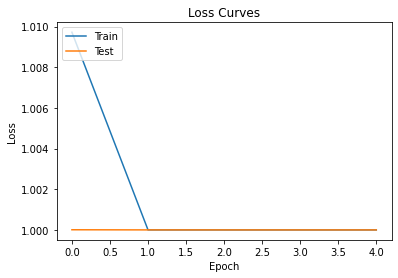

In [70]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CNN + GRU

In [73]:
model = Sequential()
model.add(Embedding(5000, 100, input_length=100))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(100))
model.add(Dense(units=num_classes, activation='sigmoid'))
model.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())
filepath="weights_best_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 550,034
Trainable params: 550,034
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
history2 = model.fit(X_train, y_train,
                    epochs=5, 
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/5
800/800 [==============================] - 11s 11ms/step - loss: 1.0829 - accuracy: 0.1349 - f1_m: 0.0011 - precision_m: 5.6677e-04 - recall_m: 0.0091 - val_loss: 1.0000 - val_accuracy: 0.0701 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
800/800 [==============================] - 9s 11ms/step - loss: 1.0000 - accuracy: 0.0714 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0701 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
800/800 [==============================] - 9s 11ms/step - loss: 1.0000 - accuracy: 0.0728 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0701 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/5
800/800 [==============================] - 9s 11ms/step - loss: 1.0000 - accuracy: 0.0713 - f1_m: 0.0000e+00 - precision_m: 0.0

In [76]:
cnngru_acc = history2.history['val_accuracy'][4]
cnngru_prec = history2.history['val_precision_m'][4]
cnngru_rec = history2.history['val_recall_m'][4]
cnngru_f1 = history2.history['val_f1_m'][4]

storeResults('CNN+GRU',cnngru_acc,cnngru_prec,cnngru_rec,cnngru_f1)

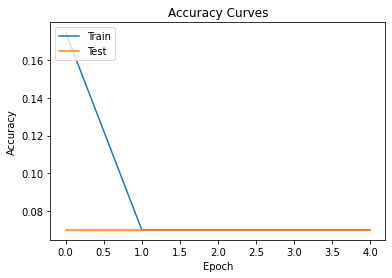

In [77]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

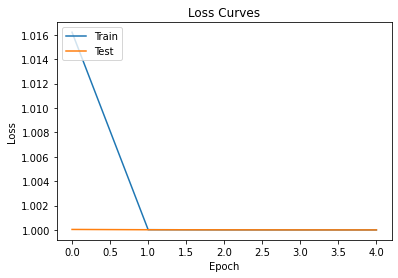

In [78]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# LSTM

In [103]:
import re
import collections
import nltk
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
import os
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import LSTM,Dropout,GRU, Bidirectional
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [104]:
#Setting parameters which will be used throughout
num_words = 15000  # Parameter indicating the number of words we'll put in the dictionary
val_size = 1000  # Size of the validation set
epochs = 20  # Number of epochs we usually start to train with
batch_size = 512  # Size of the batches used in the mini-batch gradient descent
#Taking only two columns since it's a sentiment analysis

In [105]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['tweet']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [106]:
#stops included both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
not_list = ["n't", "not", "no"]
stops.update(punctuations)
stops.update(not_list)

In [107]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [108]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops or word.lower() in not_list:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
#docs=[ clean(doc) for doc in docs]      

In [109]:
#taking only two columns in the dataframe
df=df[['tweet','label']]
df.head()

,tweet,label
0,father dysfunctional selfish drags kids dysfun...,0
1,thanks credit cant use cause offer wheelchair ...,0
2,bihday majesty,0
3,love u take u time urð± ðððð ð¦...,0
4,factsguide society,0


In [110]:
#taking variables to be used for train test split as X,y
X,Y=df['tweet'].values,pd.get_dummies(df['label'].values)

In [111]:
#using tokenizers to create the tokens having no of words=15000(num_words)
tk = Tokenizer(num_words=num_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
#Complete data is tokenized to vectors and padding is done using zeros to match its length to the largest text in the dataset.
tk.fit_on_texts(X)
X = tk.texts_to_sequences(X)
X = pad_sequences(X)
#print(X[:2])
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 31962 documents
15000 words in dictionary
Top 5 most common words are: [('\x80¦', 2617), ('day', 1975), ('amp', 1590), ('happy', 1548), ('love', 1189)]


In [112]:
import pickle
pickle.dump(tk,open('transform2.pkl','wb'))
#files.download('transform2.pkl')

In [113]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)

# Train data samples: (25569, 24)
# Test data samples: (6393, 24)


In [114]:
#Function defined to test the models in the test set
def test_model(model, epoch_stop):
    model.fit(X_train
              , Y_train
              , epochs=epoch_stop
              , batch_size=batch_size
              , verbose=0)
    results = model.evaluate(X_train, Y_train)
    
    return results

In [115]:
import collections
import nltk
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras import regularizers

In [116]:
embed_dim = 128 #dimension of the word embedding vector for each word in a sequence 
lstm_out = 196  #no of lstm layers
lstm_model = Sequential()
lstm_model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
#Adding dropout
lstm_model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#Adding a regularized dense layer
lstm_model.add(layers.Dense(32,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(Dense(2,activation='softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1_m,precision_m, recall_m])
print(lstm_model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 24, 128)           1920000   
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 196)               254800    
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 32)                6304      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 2,181,170
Trainable params: 2,181,170
Non-trainable params: 0
_________________________________________________________________
None


In [98]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history_LSTM=lstm_model.fit(X_train, Y_train, epochs = 5, batch_size=16,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/5
1599/1599 [==============================] - 249s 156ms/step - loss: 0.1129 - accuracy: 0.9648 - f1_m: 0.9648 - precision_m: 0.9648 - recall_m: 0.9648 - val_loss: 0.1643 - val_accuracy: 0.9476 - val_f1_m: 0.9471 - val_precision_m: 0.9471 - val_recall_m: 0.9471
Epoch 2/5
1599/1599 [==============================] - 250s 156ms/step - loss: 0.0696 - accuracy: 0.9771 - f1_m: 0.9771 - precision_m: 0.9771 - recall_m: 0.9771 - val_loss: 0.2091 - val_accuracy: 0.9456 - val_f1_m: 0.9458 - val_precision_m: 0.9458 - val_recall_m: 0.9458
Epoch 3/5
1599/1599 [==============================] - 251s 157ms/step - loss: 0.0448 - accuracy: 0.9857 - f1_m: 0.9857 - precision_m: 0.9857 - recall_m: 0.9857 - val_loss: 0.2532 - val_accuracy: 0.9467 - val_f1_m: 0.9469 - val_precision_m: 0.9469 - val_recall_m: 0.9469
Epoch 4/5
1599/1599 [==============================] - 251s 157ms/step - loss: 0.0312 - accuracy: 0.9904 - f1_m: 0.9904 - precision_m: 0.9904 - recall_m: 0.9904 - val_loss: 0.2551 - val_a

In [100]:
lstm_acc = trained.history['val_accuracy'][4]
lstm_prec = trained.history['val_precision_m'][4]
lstm_rec = trained.history['val_recall_m'][4]
lstm_f1 = trained.history['val_f1_m'][4]

storeResults('LSTM',lstm_acc,lstm_prec,lstm_rec,lstm_f1)

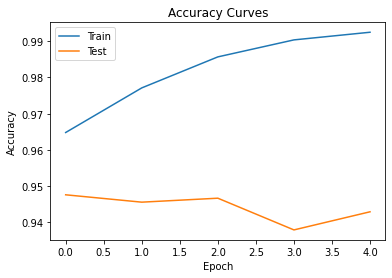

In [101]:
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

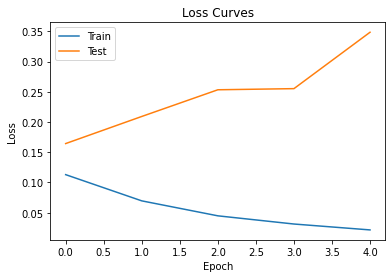

In [102]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# LSTM + GRU

In [117]:
model = Sequential()
model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
model.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model.add(GRU(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1_m,precision_m, recall_m])
print(model.summary())
filepath="weights_best_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 24, 128)           1920000   
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 24, 64)            49408     
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 32)                9408      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 1,978,882
Trainable params: 1,978,882
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
trained5 = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/5
50/50 [==============================] - 18s 361ms/step - loss: 0.0249 - accuracy: 0.9929 - f1_m: 0.9929 - precision_m: 0.9929 - recall_m: 0.9929 - val_loss: 0.0176 - val_accuracy: 0.9950 - val_f1_m: 0.9950 - val_precision_m: 0.9950 - val_recall_m: 0.9950
Epoch 2/5
50/50 [==============================] - 18s 360ms/step - loss: 0.0232 - accuracy: 0.9934 - f1_m: 0.9934 - precision_m: 0.9934 - recall_m: 0.9934 - val_loss: 0.0166 - val_accuracy: 0.9954 - val_f1_m: 0.9954 - val_precision_m: 0.9954 - val_recall_m: 0.9954
Epoch 3/5
50/50 [==============================] - 18s 361ms/step - loss: 0.0207 - accuracy: 0.9933 - f1_m: 0.9933 - precision_m: 0.9933 - recall_m: 0.9933 - val_loss: 0.0168 - val_accuracy: 0.9952 - val_f1_m: 0.9952 - val_precision_m: 0.9952 - val_recall_m: 0.9952
Epoch 4/5
50/50 [==============================] - 18s 357ms/step - loss: 0.0191 - accuracy: 0.9941 - f1_m: 0.9941 - precision_m: 0.9941 - recall_m: 0.9941 - val_loss: 0.0137 - val_accuracy: 0.9962 - va

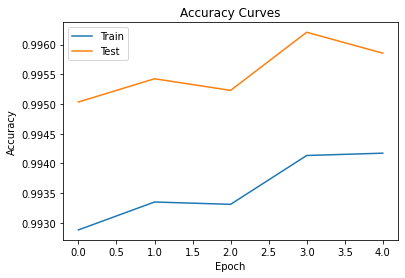

In [121]:
plt.plot(trained5.history['accuracy'])
plt.plot(trained5.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

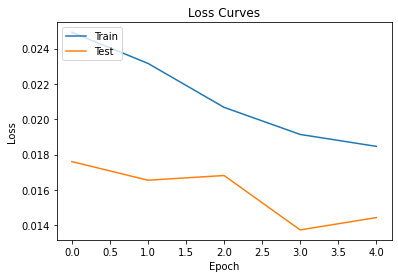

In [122]:
plt.plot(trained5.history['loss'])
plt.plot(trained5.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [124]:
lstmgru_acc = trained5.history['val_accuracy'][4]
lstmgru_prec = trained5.history['val_precision_m'][4]
lstmgru_rec = trained5.history['val_recall_m'][4]
lstmgru_f1 = trained5.history['val_f1_m'][4]

storeResults('LSTM+GRU',lstmgru_acc,lstmgru_prec,lstmgru_rec,lstmgru_f1)

# LSTM + BiGRU

In [128]:
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional

In [129]:
model = Sequential()
model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
model.add(Bidirectional(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True)))
model.add(Bidirectional(GRU(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1_m,precision_m, recall_m])
print(model.summary())
filepath="weights_best_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 24, 128)           1920000   
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 24, 128)           98816     
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 64)                31104     
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 2)                 130       
Total params: 2,050,050
Trainable params: 2,050,050
Non-trainable params: 0
_________________________________________________________________
None


In [131]:
trained6 = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/5
50/50 [==============================] - 34s 619ms/step - loss: 0.2920 - accuracy: 0.9262 - f1_m: 0.9262 - precision_m: 0.9262 - recall_m: 0.9262 - val_loss: 0.2373 - val_accuracy: 0.9285 - val_f1_m: 0.9283 - val_precision_m: 0.9283 - val_recall_m: 0.9283
Epoch 2/5
50/50 [==============================] - 30s 596ms/step - loss: 0.1777 - accuracy: 0.9393 - f1_m: 0.9394 - precision_m: 0.9394 - recall_m: 0.9394 - val_loss: 0.1696 - val_accuracy: 0.9442 - val_f1_m: 0.9441 - val_precision_m: 0.9441 - val_recall_m: 0.9441
Epoch 3/5
50/50 [==============================] - 30s 604ms/step - loss: 0.0925 - accuracy: 0.9679 - f1_m: 0.9679 - precision_m: 0.9679 - recall_m: 0.9679 - val_loss: 0.1661 - val_accuracy: 0.9463 - val_f1_m: 0.9462 - val_precision_m: 0.9462 - val_recall_m: 0.9462
Epoch 4/5
50/50 [==============================] - 30s 597ms/step - loss: 0.0616 - accuracy: 0.9794 - f1_m: 0.9794 - precision_m: 0.9794 - recall_m: 0.9794 - val_loss: 0.1830 - val_accuracy: 0.9446 - va

In [132]:
lstmgru_acc = trained6.history['val_accuracy'][4]
lstmgru_prec = trained6.history['val_precision_m'][4]
lstmgru_rec = trained6.history['val_recall_m'][4]
lstmgru_f1 = trained6.history['val_f1_m'][4]

storeResults('LSTM+BiGRU',lstmgru_acc,lstmgru_prec,lstmgru_rec,lstmgru_f1)

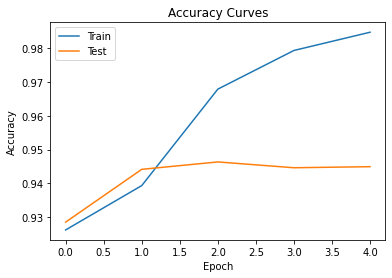

In [133]:
plt.plot(trained6.history['accuracy'])
plt.plot(trained6.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

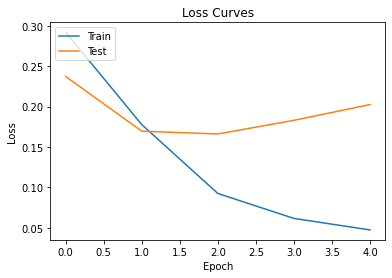

In [134]:
plt.plot(trained6.history['loss'])
plt.plot(trained6.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Machine Learning

In [181]:
import numpy as np
import re
import nltk
import pickle
from nltk.corpus import stopwords
import pandas as pd 
import warnings

In [182]:
df = pd.read_csv('train_E6oV3lV.csv')

In [183]:
df = df.dropna()

In [184]:
df['message'] = df['tweet']

In [185]:
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import string 
from nltk.stem import WordNetLemmatizer

In [186]:
Tweet = []
Labels = []

for row in df["message"]:
    #tokenize words
    words = word_tokenize(row)
    #remove punctuations
    clean_words = [word.lower() for word in words if word not in set(string.punctuation)]
    #remove stop words
    english_stops = set(stopwords.words('english'))
    characters_to_remove = ["''",'``',"rt","https","’","“","”","\u200b","--","n't","'s","...","//t.c" ]
    clean_words = [word for word in clean_words if word not in english_stops]
    clean_words = [word for word in clean_words if word not in set(characters_to_remove)]
    #Lematise words
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_list = [wordnet_lemmatizer.lemmatize(word) for word in clean_words]
    Tweet.append(lemma_list)

In [187]:
X = df['message']
y = df['label']

In [188]:
# Extract Feature With CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(stop_words='english')
X = cv.fit_transform(X) # Fit the Data

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [190]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# LinearSVC

In [191]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train, y_train) 
y_pred = svm.predict(X_test)

svm_acc = accuracy_score(y_test, y_pred)
svm_prec = precision_score(y_test, y_pred,average='weighted')
svm_rec = recall_score(y_test, y_pred,average='weighted')
svm_f1 = f1_score(y_test, y_pred,average='weighted')

In [192]:
storeResults('LinearSVC',svm_acc,svm_prec,svm_rec,svm_f1)

# Naive Bayes

In [195]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

lr_acc = accuracy_score(y_test, y_pred)
lr_prec = precision_score(y_test, y_pred,average='weighted')
lr_rec = recall_score(y_test, y_pred,average='weighted')
lr_f1 = f1_score(y_test, y_pred,average='weighted')

In [196]:
storeResults('Naive Bayes',lr_acc,lr_prec,lr_rec,lr_f1)

# Random FOrest

In [197]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier(n_estimators=10, random_state=0)

RandomForest.fit(X_train, y_train) 
y_pred = RandomForest.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred)
rf_prec = precision_score(y_test, y_pred,average='weighted')
rf_rec = recall_score(y_test, y_pred,average='weighted')
rf_f1 = f1_score(y_test, y_pred,average='weighted')

In [199]:
storeResults('Random FOrest',rf_acc,rf_prec,rf_rec,rf_f1)

# RF + SVM + NB

In [203]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

estimator = []
estimator.append(('SVM', SVC(probability=True)))
estimator.append(('RFC', RandomForestClassifier()))
estimator.append(('NB', MultinomialNB()))
vot_hard = VotingClassifier(estimators = estimator, voting ='soft')
vot_hard.fit(X_train, y_train) 
y_pred = vot_hard.predict(X_test)

vot_acc = accuracy_score(y_test, y_pred)
vot_prec = precision_score(y_test, y_pred,average='weighted')
vot_rec = recall_score(y_test, y_pred,average='weighted')
vot_f1 = f1_score(y_test, y_pred,average='weighted')

In [205]:
storeResults('RF + SVM + NB',vot_acc,vot_prec,vot_rec,vot_f1)

In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

estimators = [('rf', RandomForestClassifier(n_estimators=10)),('mlp', MLPClassifier(random_state=1, max_iter=300))]

clf = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier())
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

stac_acc_a = accuracy_score(y_test, y_pred)
stac_prec_a = precision_score(y_test, y_pred,average='weighted')
stac_rec_a = recall_score(y_test, y_pred,average='weighted')
stac_f1_a = f1_score(y_test, y_pred,average='weighted')



In [208]:
storeResults('Stacking Classifier',stac_acc_a,stac_prec_a,stac_rec_a,stac_f1_a)

# Comparison

In [209]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score,
                        
                      })

In [210]:
result

,ML Model,Accuracy,Precision,Recall,F1-Score
0,BERT,0.908,0.000,0.000,0.000
1,BiLSTM,0.930,0.070,1.000,0.130
2,GRU,0.930,0.070,1.000,0.130
3,CNN,0.930,0.070,1.000,0.130
4,CNN+LSTM,0.930,0.000,0.000,0.000
5,CNN+BiLSTM,0.930,0.070,1.000,0.130
6,CNN+GRU,0.070,0.000,0.000,0.000
7,LSTM,0.930,0.070,1.000,0.130
8,LSTM+GRU,0.996,0.996,0.996,0.996
9,LSTM+BiGRU,0.945,0.945,0.945,0.945


# Graph

In [211]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

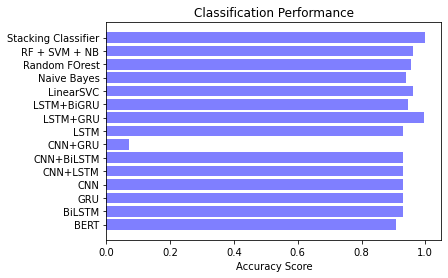

In [212]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

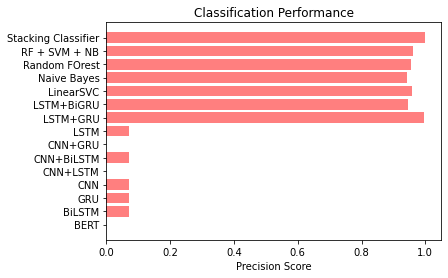

In [213]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

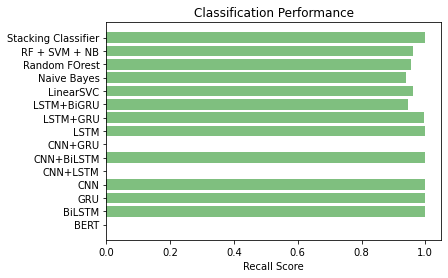

In [214]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1Score

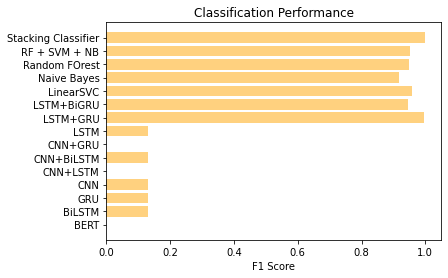

In [215]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='orange')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()